In [2]:
prfx = "trn0005" 

In [2]:
%load_ext autoreload
%autoreload 2
%aimport

!nvidia-smi

Modules to reload:
all-except-skipped

Modules to skip:

Sun Apr  4 02:30:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                   

- https://github.com/haqishen/Google-Landmark-Recognition-2020-3rd-Place-Solution
- https://www.kaggle.com/zzy990106/b0-bert-cv0-9
- https://github.com/yang-zhang/product_category/blob/dev/notebooks/transformer_20210307E1--pin_memory.ipynb

# train

In [3]:
HOME = "/data/git/shopee-product-matching"
p_out = f'{HOME}/output/{prfx}'
!mkdir -p {p_out}
p_prp = f'{HOME}/output/prep002'

FOLD = 0
FP16 = False

import sys
sys.path.append(f"{HOME}/src")

import pandas as pd
from argparse import ArgumentParser
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pl_model import ShpModel, ShpDataModule
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
parser = ArgumentParser()
parser.add_argument(
    "--imgsz",
    help="Image size.",
    type=int,
    default=224,
)
parser.add_argument(
    "--train_batch_size",
    help="How many samples per batch to load for train dataloader.",
    type=int,
    default=64,
)
parser.add_argument(
    "--val_batch_size",
    help="How many samples per batch to load for validation dataloader.",
    type=int,
    default=128,
)
parser.add_argument(
    "--dataloader_num_workers",
    help="How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.",
    type=int,
    default=8,
)
parser.add_argument(
    "--pin_memory",
    help="Wether to use pin_memory in pytorch dataloader. If True, the data loader will copy Tensors into CUDA pinned memory before returning them.",
    action="store_true",
)

parser = pl.Trainer.add_argparse_args(parser)
parser = ShpModel.add_model_specific_args(parser)
args_list = [
    '--default_root_dir', p_out,
    '--kernel-type', '',
    '--enet-type', 'tf_efficientnet_b1_ns',

]

args = parser.parse_args(args_list)

In [5]:
df = pd.read_csv(f"{p_prp}/df_train.csv")
display(df.head(3))
dftrn = df[df.fold!=FOLD].copy()
dfval = df[df.fold==FOLD].copy()
print(dftrn.shape, dfval.shape)

data_module = ShpDataModule(
    dftrn=dftrn,
    dfval=dfval,
    train_batch_size=args.train_batch_size,
    val_batch_size=args.val_batch_size,
    pin_memory=args.pin_memory,    
    
)

,index,posting_id,image,image_phash,title,label_group,filepath,fold
0,0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/data/git/shopee-product-matching/input/shopee...,0
1,1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/data/git/shopee-product-matching/input/shopee...,2
2,2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/data/git/shopee-product-matching/input/shopee...,0


(23292, 8) (5823, 8)


In [6]:
data_module.setup()
data_module.num_classes

9369

In [7]:
shpmodel = ShpModel(
    kernel_type=args.kernel_type,
    enet_type=args.enet_type,
    learning_rate=args.learning_rate,
    num_classes=data_module.num_classes,
    margins=data_module.margins,
)

In [8]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger

csv_logger = CSVLogger(p_out, name='csv')
tb_logger = TensorBoardLogger(p_out, name='tensorboard')

trainer = pl.Trainer.from_argparse_args(args, 
#                                         limit_train_batches=10, limit_val_batches=2, 
#                                         fast_dev_run=True,
                                        max_epochs=50,
                                        callbacks=[EarlyStopping(monitor='valid_accu')],
                                        stochastic_weight_avg=True,
                                        log_gpu_memory=True, 
                                        gpus=1,
                                        logger=[tb_logger,csv_logger],
                                        precision=16 if FP16 else 32,
                                       )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [9]:
pl.seed_everything(1234)
trainer.fit(shpmodel, data_module)

Global seed set to 1234
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                      | Params
-------------------------------------------------------
0 | model    | Effnet_Landmark           | 21.6 M
1 | arc      | ArcFaceLossAdaptiveMargin | 0     
2 | accuracy | Accuracy                  | 0     
-------------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.239    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/data/anaconda3/envs/shopee/lib/python3.7/site-packages/pytorch_lightning/core/step_result.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch.float)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [4]:
ls -hl {p_out}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 248M Apr  4 03:47 '/data/git/shopee-product-matching/output/trn0005/tensorboard_csv/0_0/checkpoints/epoch=23-step=8735.ckpt'


In [11]:
!nvidia-smi

Sun Apr  4 03:47:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   44C    P0    49W / 300W |   1578MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# inference

In [12]:
p_trained = p_out
imgsz = args.imgsz
enet_type = args.enet_type

import pandas as pd
from pl_model import ShpModel
import os
import torch
import numpy as np
from tqdm import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from final import enet_arcface_FINAL, load_model

## load model

In [9]:
ls -hl {p_trained}/tensorboard_csv/*/checkpoints/*.ckpt

-rw-rw-r-- 1 ubuntu ubuntu 248M Apr  4 03:47 '/data/git/shopee-product-matching/output/trn0005/tensorboard_csv/0_0/checkpoints/epoch=23-step=8735.ckpt'


In [14]:
ckpt = f'{p_trained}/tensorboard_csv/0_0/checkpoints/epoch=23-step=8735.ckpt'
shpmodel = ShpModel.load_from_checkpoint(ckpt)
out_dim = shpmodel.num_classes

In [15]:
device = torch.device('cuda')

In [16]:
model = enet_arcface_FINAL(enet_type, out_dim=out_dim).to(device)
model = load_model(model, shpmodel)
model = model.to(device)

## dataloader

In [17]:
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader

df = pd.read_csv(f'{p_prp}/df_valid.csv')

pids = df.posting_id.values

tfms_trn, tfms_val = get_transforms(imgsz)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=32,
            num_workers=8,
            pin_memory=True,
        )

## get feats

In [18]:
for dat in dl:
    dat = dat.to(device)
    with torch.no_grad():
        feat,_ = model(dat)
    break

feat.shape

torch.Size([32, 512])

In [19]:
feats = np.zeros((len(ds), feat.shape[1]))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        feat,_ = model(dat)
        l = len(feat)
        feats[i : i + l, :] = feat.cpu().detach().numpy()
        i += l

100%|██████████| 161/161 [00:18<00:00,  8.93it/s]


In [20]:
feats.shape

(5135, 512)

## verify

In [21]:
import torch
import numpy as np
from tqdm import tqdm

from utils import meanf1, get_targets, get_preds_by_thrsh, preds2pids
from neighbor import get_nbrs

In [22]:
targets = get_targets(df)

In [23]:
dists, idx = get_nbrs(feats)

chunk 0 to 4096
chunk 4096 to 5135


In [24]:
preds = get_preds_by_thrsh(dists, idx, thrsh=1.)
preds = preds2pids(preds, pids)

In [25]:
meanf1(preds,targets)

0.7136844061555048

In [26]:
thrshes = np.linspace(1.1,1.2,num=11)
print(thrshes)

[1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2 ]


In [27]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    preds = preds2pids(preds, pids)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


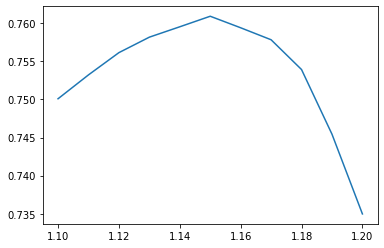

In [28]:
import matplotlib.pyplot as plt
plt.plot(thrshes, f1_lst)  

In [29]:
def find_best(dists, idx, thrshes = np.linspace(1.75,2.25,num=11)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [30]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)

100%|██████████| 11/11 [00:02<00:00,  5.44it/s]


In [31]:
f1_best, thrsh_best

(0.7609242419067154, 1.15)

# inference on train

In [32]:
from dataset import ShopeeDataset, get_transforms
from torch.utils.data import DataLoader

df = pd.read_csv(f'{p_prp}/df_train.csv')

pids = df.posting_id.values

tfms_trn, tfms_val = get_transforms(imgsz)
ds = ShopeeDataset(df, mode="test", transform=tfms_val)
dl = DataLoader(ds,
            batch_size=32,
            num_workers=8,
            pin_memory=True,
        )

## get feats

In [33]:
feats = np.zeros((len(ds), feat.shape[1]))
i = 0
for dat in tqdm(dl):
    with torch.no_grad():
        dat = dat.to(device)
        feat,_ = model(dat)
        l = len(feat)
        feats[i : i + l, :] = feat.cpu().detach().numpy()
        i += l

100%|██████████| 910/910 [01:36<00:00,  9.47it/s]


In [34]:
feats.shape

(29115, 512)

## verify

In [35]:
import torch
import numpy as np
from tqdm import tqdm

from utils import meanf1, get_targets, get_preds_by_thrsh, preds2pids
from neighbor import get_nbrs

In [36]:
targets = get_targets(df)

In [37]:
dists, idx = get_nbrs(feats)

chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 29115


In [38]:
preds = get_preds_by_thrsh(dists, idx, thrsh=1.)
preds = preds2pids(preds, pids)

In [39]:
meanf1(preds,targets)

0.7943977967789698

In [40]:
thrshes = np.linspace(1.1,1.2,num=11)
print(thrshes)

[1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2 ]


In [41]:
f1_lst = []
for thrsh in tqdm(thrshes):
    preds = get_preds_by_thrsh(dists, idx, thrsh)
    preds = preds2pids(preds, pids)
    f1_lst.append(meanf1(preds,targets))

100%|██████████| 11/11 [00:11<00:00,  1.04s/it]


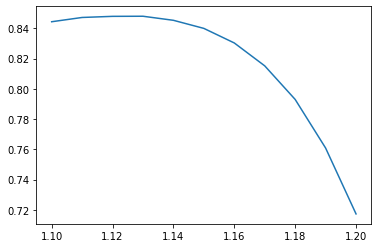

In [42]:
import matplotlib.pyplot as plt
plt.plot(thrshes, f1_lst)  

In [43]:
def find_best(dists, idx, thrshes = np.linspace(1.75,2.25,num=11)):
    f1_lst = []
    preds_lst = []
    for thrsh in tqdm(thrshes):
        preds = get_preds_by_thrsh(dists, idx, thrsh)
        preds = preds2pids(preds, pids)
        preds_lst.append(preds)
        f1 = meanf1(preds,targets)
        f1_lst.append(f1)
    f1_best, thrsh_best, preds_best = sorted(zip(f1_lst, thrshes, preds_lst), reverse=True)[0]
    return f1_best, thrsh_best, preds_best

In [44]:
f1_best, thrsh_best, preds_best = find_best(dists, idx, thrshes)

100%|██████████| 11/11 [00:11<00:00,  1.05s/it]


In [45]:
f1_best, thrsh_best

(0.8479389394457949, 1.1300000000000001)

# save weight

In [11]:
ckpt

'/data/git/shopee-product-matching/output/trn0005/tensorboard_csv/0_0/checkpoints/epoch=23-step=8735.ckpt'

In [12]:
!cp {ckpt} {p_trained}/